# E07 Single neuron simulation

In [1]:
# Imports/preparations for later
from brian2 import *
prefs.codegen.target = 'numpy'  # switch off code generation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## LIF model: verifying the match between analytical solutions and simulations

During the tutorial, we used the following equations for the leaky integrate-and-fire neuron model:
$$
dV/dt = \left(g_L\left(E_L - V\right) + I_\text{stim}\right)/C
$$

### Questions

1. For given values of $g_L$, $E_L$, and $C$ and a weak, constant input current $I_\text{stim}$ (weak enough to not drive the neuron over its threshold), what is the *steady-state membrane potential*, i.e. the final membrane potential after which it no longer changes?

*Hint*:
- $V$ is at its steady-state value, if its rate of change ($dV/dt$) is zero.

#### Solution
\begin{align}
0 &= \left(g_L\left(E_L - V_\text{steady}\right) + I_\text{stim}\right)/C \\
0 &= g_L\left(E_L - V_\text{steady}\right) + I_\text{stim} \\
-I_\text{stim}/g_L &= E_L - V_\text{steady} \\
-I_\text{stim}/g_L -E_L &= - V_\text{steady} \\
V_\text{steady} &=  I_\text{stim}/g_L + E_L \\
\end{align}

Below is the tutorial code we used to simulate a leaky integrate-and-fire neuron:

In [2]:
# Parameters
area = 20000*umetre**2
C = (1*ufarad*cm**-2) * area
g_L = (50*usiemens*cm**-2) * area
E_L = -60*mV

#Equations
lif_eqs = """
dV/dt = (g_L*(E_L - V) + I_stim)/C : volt (unless refractory)
I_stim : amp (constant)
"""

In [3]:
start_scope()

neuron = NeuronGroup(1, lif_eqs, threshold="V>-50*mV", reset="V=-80*mV", refractory=5*ms, method='euler')
neuron.V = E_L
neuron.I_stim = 0.5*nA

mon = StateMonitor(neuron, "V", record=0)
run(300*ms)

2. Use the above code to simulate the neuron with a *weak, sub-threshold* (but not zero …) current. Print both your analytical prediction for the steady state voltage, and the actual voltage at the end of the simulation.

In [5]:
# Solution
start_scope()

neuron = NeuronGroup(1, lif_eqs, threshold="V>-50*mV", reset="V=-80*mV", refractory=5*ms, method='euler')
neuron.V = E_L
neuron.I_stim = 0.05*nA

mon = StateMonitor(neuron, "V", record=0)
run(300*ms)

print("Prediction  : ", neuron.I_stim[0]/g_L + E_L)
print("Actual value: ", neuron.V[0])

Prediction  :  -55. mV
Actual value:  -55.00000147 mV


## HH model: current pulse
In the tutorial, we've simulated the HH model in response to a constant current injection. Now, we are looking in more detail at the shape of a single action potential, by injecting a *pulse current*.

In [6]:
# Parameter
area = 20000*umetre**2
C = (1*ufarad*cm**-2) * area
g_L = (50*usiemens*cm**-2) * area
VT = -52
E_L = -60*mV
E_K = -90*mV
E_Na = 50*mV
gbar_Na = (100*msiemens*cm**-2) * area
gbar_K = (30*msiemens*cm**-2) * area

# Equations
hh_eqs = """
dV/dt = (I_L + I_Na + I_K + I_stim)/C : volt
I_L = g_L*(E_L - V) : amp
I_Na = g_Na*(E_Na - V) : amp
g_Na = gbar_Na*m**3*h : siemens
I_K = g_K*(E_K - V) : amp
g_K = gbar_K*n**4 : siemens

dn/dt = (n_inf - n)/tau_n : 1
tau_n = 1/(alpha_n + beta_n) : second
n_inf = alpha_n/(alpha_n + beta_n) : 1

dm/dt = (m_inf - m)/tau_m : 1
tau_m = 1/(alpha_m + beta_m) : second
m_inf = alpha_m/(alpha_m + beta_m) : 1

dh/dt = (h_inf - h)/tau_h : 1
tau_h = 1/(alpha_h + beta_h) : second
h_inf = alpha_h/(alpha_h + beta_h) : 1

V_ = V/mV : 1  # for shorter equations below
alpha_m = 0.32*4/exprel((13-V_+VT)/4)/ms : Hz
beta_m = 0.28*5/exprel((V_-VT-40)/5)/ms : Hz
alpha_h = 0.128*exp((17-V_+VT)/18)/ms : Hz
beta_h = 4./(1+exp((40-V_+VT)/5))/ms : Hz
alpha_n = 0.032*5/exprel((15-V_+VT)/5)/ms : Hz
beta_n = .5*exp((10-V_+VT)/40)/ms : Hz
I_stim : amp (constant)
"""

In [7]:
start_scope()
hh_neuron = NeuronGroup(1, hh_eqs, method="exponential_euler")
hh_neuron.V = E_L

hh_mon = StateMonitor(hh_neuron, "V", record=0)

# no input for 50ms, strong pulse for 2ms, no input for the rest of the simulation
run(50*ms)

hh_neuron.I_stim = 2*nA
run(2*ms)

hh_neuron.I_stim = 0*nA
run(248*ms)

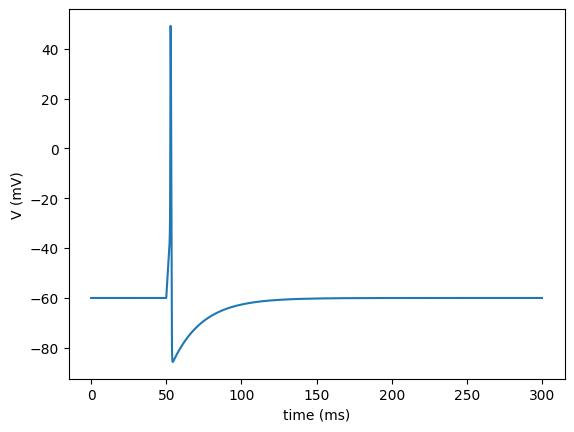

In [8]:
plt.plot(hh_mon.t/ms, hh_mon.V[0]/mV)
plt.xlabel("time (ms)"); plt.ylabel("V (mV)");

### Question
3. Characterize the action potential with the following values:
   - peak height (peak of action potential relative to resting potential)
   - peak latency (time of peak relative to onset of stimulus)
   - minimum afterhyperpolarization (minimum of action potential after spike)
   - length of afterhyperpolarization (time after the minimum afterhyperpolarization where the membrane potential is within 1mV of resting potential)
  
*Hints*:
- numpy's `argmin`, `argmax` functions can be helpful to get indices for the times in `hh_mon.t`
- In numpy, you can index arrays with boolean values, e.g. `hh_mon.t[hh_mon.V[0] > -60*mV]` will give all the times where the membrane potential was above -60mV

In [10]:
# Solution
# Resting potential can be calculated in several ways, here the easiest would be to take the value at the very end of the simulation
# E_L is also a reasonable choice, it is barely distinguishable in this model
resting_potential = hh_neuron.V[0]  # Value after simulation
print("resting potential:", resting_potential, "(E_L: ", E_L, ")")
print("peak height", hh_mon.V[0].max() - resting_potential)
print("peak latency", mon.t[hh_mon.V[0].argmax()] - 50*ms)
print("minimum AHP", hh_mon.V[0].min())
print("length of AHP", hh_mon.t[hh_mon.V[0] < resting_potential - 1*mV][-1] - 50*ms)

resting potential: -59.99625366 mV (E_L:  -60. mV )
peak height 109.12139884 mV
peak latency 2.9 ms
minimum AHP -85.6521245 mV
length of AHP 69.4 ms
